In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from PIL import Image

# load images

Both cityscape and GSV images

### cityscape images

npz files (zip file of numpy arrays)

In [3]:
cityscape_Xtrain = np.load("data/input_data/cityscape_npz/cityscape_train_raw_final.npz" )
cityscape_Xval = np.load("data/input_data/cityscape_npz/cityscape_val_raw_final.npz" )

cityscape_Ytrain = np.load("data/input_data/cityscape_npz/cityscape_train_lbl_final.npz")
cityscape_Yval = np.load("data/input_data/cityscape_npz/cityscape_val_lbl_final.npz" )

FileNotFoundError: [Errno 2] No such file or directory: 'data/input_data/cityscape_npz/cityscape_train_raw_final.npz'

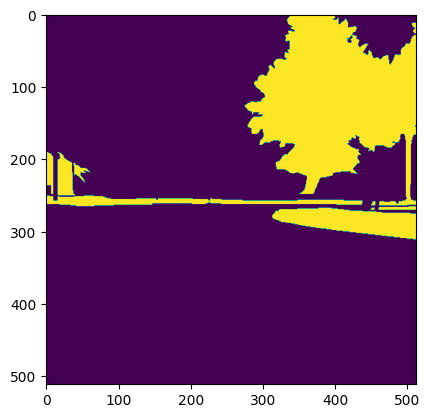

In [ ]:
plt.imshow(cityscape_Ytrain['array_0'])

In [ ]:

def npz_to_npy(npz):
  npy_list = []
  for file in npz.files:
    npy_list.append(npz[file].copy())

  npy_arr = np.array(npy_list, dtype=np.uint8)
  del npy_list

  return npy_arr

In [ ]:
def resize_to_224(arr):
  resized = np.zeros((len(arr), 224, 224, 3), dtype=np.uint8)
  for i in range(len(arr)):
    resized[i] = np.asarray(Image.fromarray(arr[i]).resize((224, 224)))

  return resized

In [ ]:
cityscape_Xtrain = npz_to_npy(cityscape_Xtrain)
cityscape_Xval  = npz_to_npy(cityscape_Xval)

# resize array to (224, 224)
cityscape_Xtrain224 = resize_to_224(cityscape_Xtrain)
cityscape_Xval224 = resize_to_224(cityscape_Xval)

In [ ]:
# compute GVI based on label pixels
cityscape_Ytrain_GVI = np.expand_dims(np.mean(npz_to_npy(cityscape_Ytrain), axis=(1,2)), axis=-1)
cityscape_Yval_GVI =  np.expand_dims(np.mean(npz_to_npy(cityscape_Yval), axis=(1,2)), axis=-1)

In [ ]:
cityscape_Yval_GVI.max()

0.6967315673828125

# define DeepLabv3+ model


In [ ]:
from tensorflow.keras import layers

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
from tensorflow import keras
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

    return keras.Model(inputs=model_input, outputs=model_output)


DLV3_model224 = DeeplabV3Plus(image_size=224, num_classes=2)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
DLV3_model224.output

<KerasTensor: shape=(None, 224, 224, 2) dtype=float32 (created by layer 'conv2d_9')>

In [ ]:
#from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import plot_model
#plot_model(DLV3_model,show_shapes=True)

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import metrics

class MyHyperModel(kt.HyperModel):
    def build(self, hp):    # this method can only be named `build`, cannot be changed
        # Define the initial number of units for the first layer
        #units_previous = hp.Int('units_0', min_value=32, max_value=512, step=32)

        x = DLV3_model224.output
        x = layers.Dense(units=320)(x)
        x = layers.Dense(units=160)(x)
        x = layers.Dense(units=64)(x)
        x = layers.Dense(units=32)(x)

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        
        model = keras.Model(inputs=DLV3_model224.input, outputs=x)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(loss='binary_crossentropy', 
                           optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                           metrics=[metrics.MeanAbsoluteError()])

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=32,
            **kwargs,
        )

In [ ]:
'''tuner = kt.Hyperband(
    hypermodel=MyHyperModel(),
    objective='val_mean_absolute_error',
    max_epochs=100,
    factor=3,
    hyperband_iterations=1,
    seed=42
)'''

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_mean_absolute_error',
    max_trials= 5,
    executions_per_trial=1,
    project_name='my_project'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_mean_absolute_error",
                min_delta=0.0001,
                patience=3,
                verbose=1,
                mode="auto",
                baseline=None,
                restore_best_weights=True)

#tuner.search(cityscape_Xtrain, cityscape_Ytrain_GVI, epochs=15, validation_data=(cityscape_Xval, cityscape_Yval_GVI), callbacks=[early_stopping])
tuner.search(cityscape_Xtrain224, cityscape_Ytrain_GVI, epochs=15, validation_data=(cityscape_Xval224, cityscape_Yval_GVI), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=3)
best_hps

Trial 3 Complete [00h 04m 49s]
val_mean_absolute_error: 0.06059691682457924

Best val_mean_absolute_error So Far: 0.06059691682457924
Total elapsed time: 00h 07m 19s


In [ ]:
print(best_hps[1].get('learning_rate'))

0.0001


In [ ]:
# Build the model with the best hyperparameters
my_model = MyHyperModel()
DLV3_model224 = my_model.build(best_hps[1])
DLV3_model224

In [ ]:
import time
st =  time.time()

history = my_model.fit(best_hps[1], 
                       DLV3_model224, 
                       cityscape_Xtrain224, cityscape_Ytrain_GVI, 
                       epochs=50, 
                       validation_data=(cityscape_Xval224, cityscape_Yval_GVI), 
                       callbacks=[early_stopping])
'''DCNN_model.fit(
    X_train, 
    y_train_GVI,
    epochs=100,
    batch_size = 64,
    validation_data=(X_valid, y_valid_GVI),
    callbacks=early_stopping
)'''

et =  time.time()
elapsed_time = et - st
print('training time = ', elapsed_time,'seconds')

Epoch 1/50
93/93 [==============================] - 65s 305ms/step - loss: 0.4131 - mean_absolute_error: 0.0783 - val_loss: 0.4097 - val_mean_absolute_error: 0.0532
Epoch 2/50
93/93 [==============================] - 27s 291ms/step - loss: 0.3925 - mean_absolute_error: 0.0554 - val_loss: 0.4110 - val_mean_absolute_error: 0.0534
Epoch 3/50
93/93 [==============================] - 27s 291ms/step - loss: 0.3919 - mean_absolute_error: 0.0548 - val_loss: 0.4091 - val_mean_absolute_error: 0.0519
Epoch 4/50
93/93 [==============================] - 27s 291ms/step - loss: 0.3913 - mean_absolute_error: 0.0537 - val_loss: 0.4103 - val_mean_absolute_error: 0.0534
Epoch 5/50
93/93 [==============================] - 27s 291ms/step - loss: 0.3912 - mean_absolute_error: 0.0541 - val_loss: 0.4120 - val_mean_absolute_error: 0.0549
Epoch 6/50
93/93 [==============================] - 27s 292ms/step - loss: 0.3905 - mean_absolute_error: 0.0536 - val_loss: 0.4084 - val_mean_absolute_error: 0.0515
Epoch 7/50

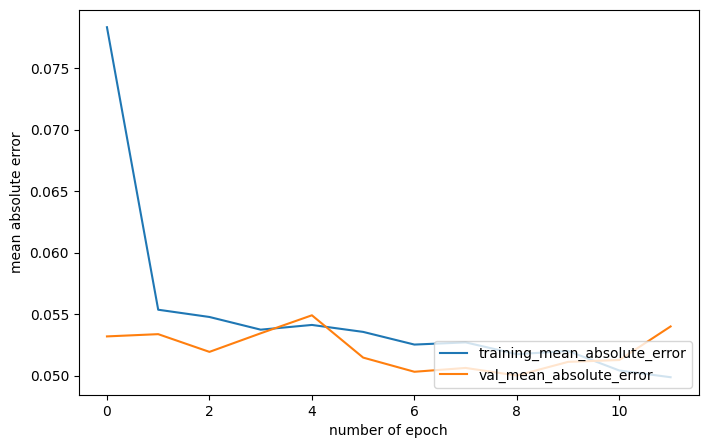

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1, figsize = (8,5))
ax.plot(history.history['mean_absolute_error'])
ax.plot(history.history['val_mean_absolute_error'])

plt.legend(["training_mean_absolute_error", "val_mean_absolute_error"], loc ="lower right")
plt.xlabel('number of epoch')
plt.ylabel('mean absolute error')

plt.show()

In [ ]:
DLV3_model224.save("/content/drive/MyDrive/XJ-Project2//DLV3_model_cityscape_pretrain.hdf5")